# Virtual Twins (VT) Method for Estimating Individual Treatment Effects (ITE)

The Virtual Twins (VT) method is a machine learning approach to estimating Individual Treatment Effects (ITE) in randomized controlled trials (RCTs). This method involves multiple steps, including data preparation, training predictive models, computing ITE, and identifying subgroups that benefit from treatment.

---

## Step 1: Data Preparation
Before implementing the VT method, we must ensure that the dataset is clean and formatted correctly. The dataset contains a binary outcome (*survival*), a treatment variable (*THERAPY*), and several covariates.

### Mathematical Formulation:
Let:

- \( Y \) be the outcome variable (survival).
- \( T \) be the treatment assignment (*THERAPY*), where \( T = 1 \) represents treatment and \( T = 0 \) represents control.
- \( X \) be the set of covariates describing patient characteristics.

### Implementation:
- Load the dataset from a `.csv` file.
- Define the outcome (*survival*) and treatment (*THERAPY*) variables.
- Preprocess the data by handling missing values and encoding categorical variables if necessary.

---

In [3]:
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from Functions.vt_data import VTObject
from Functions.vt_data import VTForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm

# Step 1: Load dataset
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')
print("✅ Dataset Loaded Successfully")
print(sepsis_data.head(10))


✅ Dataset Loaded Successfully
   survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6     BLLPLAT  \
0         0        1        19  42.921     15         1   301.80  191.000000   
1         1        1        48  68.818     11         2   118.90  264.156481   
2         0        1        20  68.818     15         2    92.80  123.000000   
3         0        1        19  33.174     14         2  1232.00  244.000000   
4         0        1        48  46.532      3         4  2568.00   45.000000   
5         0        0        21  56.098     14         1   162.65  137.000000   
6         1        0        19  68.818     15         2  2568.00   45.000000   
7         0        1        19  46.532     15         3  4952.00   92.000000   
8         0        1        22  56.098     15         3   118.90  148.601978   
9         1        1        19  56.098     10         3  2568.00  109.000000   

    BLLBILI  BLLCREAT  TIMFIRST      BLADL  blSOFA  
0  2.913416  1.000000     17.17   0.

### Preprocessing and subsets

In [4]:
#Define Outcome and Treatment Fields
outcome_field = "survival"     # Binary outcome (1 = survived, 0 = died)
treatment_field = "THERAPY"    # 1 = active treatment, 0 = control

#Initialize VTObject with interactions enabled
vt_object = VTObject(sepsis_data, outcome_field, treatment_field, interactions=False)

#Prepare Features (X_simple) and Outcome (y)
y = vt_object.get_Y()
treatment = vt_object.get_treatment()

#Simple Random Forest
featuresWithY = [col for col in sepsis_data.columns if col != outcome_field]
X_simple = sepsis_data[featuresWithY]

#Double Random Forest
X_double = vt_object.get_X()

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X_double, y, treatment, test_size=0.3, random_state=42, stratify=treatment
)

#K-Fold Cross Validation
features = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]
X_kfold = vt_object.get_X().values
y_kfold = vt_object.get_Y().values
treatment_kfold = sepsis_data[treatment_field].values



# Training the Models

### Simple Random Forest Approach
The **Simple Random Forest Approach** trains a single **Random Forest model** on the **entire dataset**, including both treated and control patients.

#### Mathematical Formulation:
Instead of training separate models for treated and control groups, we train a single model:

$$
P(Y = 1 \mid T, X)
$$

This model learns the probability of survival given both the treatment and covariates.

#### Implementation:
1. Train a **single Random Forest model** using the entire dataset, including the treatment variable.
2. Use the model to predict survival probabilities for both scenarios:
   - **With treatment** $( T = 1 )$.
   - **Without treatment** $( T = 0 )$.
3. Compute **ITE** by taking the difference between the predicted probabilities.

This approach is computationally simpler but may introduce bias compared to the **Double Random Forest Approach**.

---

In [5]:
#Train a Single Random Forest Model
print("🚀 Training Single Random Forest Model...")

rf_unified = RandomForestClassifier(n_estimators=200, random_state=123)
rf_unified.fit(X_simple, y)

print("✅ Single Random Forest Training Complete")
    
#Predict Outcomes Under Treatment and Control
X_treated = X_simple.copy()
X_treated[treatment_field] = 1  # Set treatment to 1 for all

X_control = X_simple.copy()
X_control[treatment_field] = 0  # Set treatment to 0 for all

# Predict probabilities
P1_hat_simple = rf_unified.predict_proba(X_treated)[:, 1]  # P(Y=1 | T=1, X)
P0_hat_simple = rf_unified.predict_proba(X_control)[:, 1]  # P(Y=1 | T=0, X)

🚀 Training Single Random Forest Model...
✅ Single Random Forest Training Complete


### Double Random Forest Approach (More Robust)
To improve accuracy, we implement the **Double Random Forest Approach**, which trains two separate models:

$$
\hat{P}_1(X) = P(Y = 1 \mid T = 1, X)
$$

$$
\hat{P}_0(X) = P(Y = 1 \mid T = 0, X)
$$

where:

- $( \hat{P}_1(X) )$ is the predicted probability of survival under treatment.
- $( \hat{P}_0(X) )$ is the predicted probability of survival under control.

#### Implementation:
1. Train **one Random Forest model** using only the **treated group** $( T = 1 )$.
2. Train **another Random Forest model** using only the **control group** $( T = 0 )$.
3. Compute **ITE** for each patient:

   $$
   ITE_i = \hat{P}_1(X_i) - \hat{P}_0(X_i)
   $$

In [6]:
#Subset into treated and control groups
X_treated = X_train[t_train == 1]
y_treated = y_train[t_train == 1]
X_control = X_train[t_train == 0]
y_control = y_train[t_train == 0]

#Train Random Forest Models
print("🚀 Training Double Random Forest Models using Virtual Twin...")

model_rf_trt1 = RandomForestClassifier(n_estimators=200, random_state=123)
model_rf_trt0 = RandomForestClassifier(n_estimators=200, random_state=123)
# model_rf_trt1 = RandomForestRegressor(n_estimators=200, random_state=123)
# model_rf_trt0 = RandomForestRegressor(n_estimators=200, random_state=123)

model_rf_trt1.fit(X_treated, y_treated)
model_rf_trt0.fit(X_control, y_control)

print("✅ Double Random Forest Training Complete")

#Compute ITE and probabilities
P1_hat_double = model_rf_trt1.predict(X_test)
P0_hat_double = model_rf_trt0.predict(X_test)


🚀 Training Double Random Forest Models using Virtual Twin...
✅ Double Random Forest Training Complete



#### **Comparison of Approaches**
| Approach                  | Description | Strengths | Weaknesses |
|---------------------------|-------------|------------|------------|
| **Simple Random Forest** | Single RF model trained on entire dataset | Computationally efficient | May introduce bias |
| **Double Random Forest** | Separate RF models for treated and control groups | More accurate | Requires more computational power |

### K-Fold Cross-Validation for Robustness
Instead of training models on the full dataset, we use **K-Fold Cross-Validation** to prevent overfitting. This ensures that the model does not use the same data for training and prediction.

### Implementation:
- Split the dataset into $( k )$ folds.
- Train the model on $( k-1 )$ folds and test it on the remaining fold.
- Repeat $( k )$ times and average the results.

---

In [7]:
# Initialize K-Fold parameters
k_folds = 5  # Number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=123)

# Initialize storage for predictions
P1_hat_kfold = np.zeros(len(X_kfold))  # Probability of survival for treated (P1i^)
P0_hat_kfold = np.zeros(len(X_kfold))  # Probability of survival for control (P0i^)

print(f"🚀 Running {k_folds}-Fold Cross-Validation...")

# Perform K-Fold Training
for train_index, test_index in kf.split(X_kfold):
    
    # Create train-test splits
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y[train_index], y[test_index]
    treatment_train, treatment_test = treatment_kfold[train_index], treatment_kfold[test_index]

    # Train separate models for treated and control groups
    X_train_treated = X_train[treatment_train == 1]
    y_train_treated = y_train[treatment_train == 1]

    X_train_control = X_train[treatment_train == 0]
    y_train_control = y_train[treatment_train == 0]

    rf_treated = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_treated.fit(X_train_treated, y_train_treated)

    rf_control = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_control.fit(X_train_control, y_train_control)

    # Predict probabilities for test set
    P1_hat_kfold[test_index] = rf_treated.predict_proba(X_test)[:, 1]
    P0_hat_kfold[test_index] = rf_control.predict_proba(X_test)[:, 1]

print("✅ K-Fold Cross-Validation Complete")

🚀 Running 5-Fold Cross-Validation...
✅ K-Fold Cross-Validation Complete


### Compute ITE Absolute method

In [8]:
ITE_simple = P1_hat_simple - P0_hat_simple
ITE_double = P1_hat_double - P0_hat_double
ITE_kfold = P1_hat_kfold - P0_hat_kfold

## Results

Simple Random Forest Result

In [17]:
# Calculate ITE and Classify
effect_labels = ["Beneficial" if ite > 0 else "Harmful" if ite < 0 else "No Effect" for ite in ITE_simple]

# Save Results
simplerandom = sepsis_data.copy()
simplerandom["P1_hat"] = P1_hat_simple
simplerandom["P0_hat"] = P0_hat_simple
simplerandom["ITE"] = ITE_simple
simplerandom["Effect_Label"] = effect_labels

output_path = os.path.join("dataset", "SimpleRandomForest.csv")
simplerandom.to_csv(output_path, index=False)

print("✅ ITE computation complete. Results saved to:", output_path)
print(simplerandom[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(20))

✅ ITE computation complete. Results saved to: dataset\SimpleRandomForest.csv
    P1_hat  P0_hat    ITE Effect_Label
0    0.165   0.180 -0.015      Harmful
1    0.925   0.705  0.220   Beneficial
2    0.100   0.185 -0.085      Harmful
3    0.050   0.130 -0.080      Harmful
4    0.120   0.180 -0.060      Harmful
5    0.135   0.145 -0.010      Harmful
6    0.650   0.795 -0.145      Harmful
7    0.060   0.180 -0.120      Harmful
8    0.060   0.120 -0.060      Harmful
9    0.760   0.695  0.065   Beneficial
10   0.240   0.185  0.055   Beneficial
11   0.795   0.710  0.085   Beneficial
12   0.170   0.245 -0.075      Harmful
13   0.885   0.630  0.255   Beneficial
14   0.425   0.160  0.265   Beneficial
15   0.255   0.175  0.080   Beneficial
16   0.205   0.185  0.020   Beneficial
17   0.040   0.070 -0.030      Harmful
18   0.105   0.175 -0.070      Harmful
19   0.190   0.210 -0.020      Harmful


Double Random Forest Result

In [20]:
# Save results
doublerandom = X_test.copy()
doublerandom["P1_hat"] = P1_hat_double
doublerandom["P0_hat"] = P0_hat_double
doublerandom["ITE"] = ITE_double

# # Add effect label
# def label_effect(ite):
#     if ite > 0:
#         return "Beneficial"
#     elif ite < 0:
#         return "Harmful"
#     else:
#         return "No Effect"

# doublerandom["Effect_Label"] = doublerandom["ITE"].apply(label_effect)

# Save results
output_path = os.path.join("dataset", "DoubleRandom.csv")
doublerandom.to_csv(output_path, index=False)

print(f"📁 Results saved to: {output_path}")
print(doublerandom[["P1_hat", "P0_hat", "ITE", "Effect_Label"]].head(20))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

K Fold Result

In [12]:
# Store results in DataFrame
kfold = sepsis_data.copy()
kfold["P1_hat"] = P1_hat_kfold
kfold["P0_hat"] = P0_hat_kfold
kfold["ITE"] = ITE_kfold

print("✅ Computation of Individual Treatment Effects (ITE) Complete")
print(kfold[["P1_hat", "P0_hat", "ITE"]].head(20))

#  Save results
kfold.to_csv("dataset/Kfold.csv", index=False)

✅ Computation of Individual Treatment Effects (ITE) Complete
    P1_hat  P0_hat    ITE
0    0.260   0.625 -0.365
1    0.770   0.600  0.170
2    0.250   0.360 -0.110
3    0.145   0.290 -0.145
4    0.395   0.395  0.000
5    0.205   0.430 -0.225
6    0.350   0.450 -0.100
7    0.120   0.475 -0.355
8    0.175   0.345 -0.170
9    0.245   0.195  0.050
10   0.285   0.495 -0.210
11   0.650   0.340  0.310
12   0.560   0.250  0.310
13   0.820   0.450  0.370
14   0.780   0.300  0.480
15   0.500   0.375  0.125
16   0.335   0.385 -0.050
17   0.095   0.315 -0.220
18   0.265   0.430 -0.165
19   0.585   0.335  0.250


# Visualization and Results

### 1. Classification

The **classification tree** helps categorize patients based on whether the treatment is beneficial.

### Mathematical Formula:
A classification model is trained to predict whether a patient benefits from treatment based on their covariates:

$$
Z_i =
\begin{cases} 
1, & \text{if } ITE_i > 0 \\
0, & \text{otherwise}
\end{cases}
$$

where $( Z_i )$ is an indicator variable denoting whether the treatment is beneficial for patient $( i )$.

### Implementation:
- We choose the ITE with the models trained on **Double Random Forest** to avoid bias
- Train a classifier using the estimated $( ITE )$ values.
- Identify the subgroups for which the treatment is most effective.


In [13]:
# Define Z* (Binary Classification)
# User-defined threshold (c) using quantiles of the ITE distribution
thresholds = np.quantile(ITE_double, q=np.arange(0.5, 0.9, 0.1))  # 50th to 80th percentiles

# Create a dictionary to store classification trees for different thresholds
classification_trees = {}

# Loop through each threshold to train a classification tree for each
for c in thresholds:
    # Z_star: Binary classification based on ITE threshold
    Z_star = (ITE_double > c).astype(int)  # 1 if ITE > c, else 0

    # Split the data into training and testing sets
    X_train, X_test, Z_train, Z_test = train_test_split(X_double, Z_star, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, Z_train)

    # Store the trained model with a descriptive name based on the threshold
    classification_trees[f"tree_threshold_{c:.2f}"] = clf

# Display the trained classification trees
print(f"Trained classification trees: {list(classification_trees.keys())}")

# Choose the model with the closest threshold (e.g., closest to 0.75)
# You can customize this logic to choose based on other criteria as needed.
closest_threshold = 0.75  # For example, we can pick 0.75 if it exists, or the closest one
closest_key = min(classification_trees.keys(), key=lambda k: abs(float(k.split('_')[-1]) - closest_threshold))

# Feature names for the decision tree plot
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X_double.shape[1])]

# Plot the tree for the selected model
plt.figure(figsize=(12, 6))
plot_tree(classification_trees[closest_key], feature_names=feature_names, class_names=["No Benefit", "Benefit"], filled=True)
plt.title(f"Decision Tree for Threshold {closest_threshold}")
plt.show()

# Train decision tree for subgroup identification
tree = classification_trees[closest_key]

# Print decision rules
print("\nDecision Tree Rules:")
print(export_text(tree, feature_names=features))

# Assign subgroup IDs using the tree
doublerandom = pd.read_csv("dataset/DoubleRandom.csv")
doublerandom["Subgroup"] = tree.apply(X_double)

# Calculate subgroup statistics
subgroup_stats = doublerandom.groupby("Subgroup").agg(
    Treatment_size=("THERAPY", lambda x: (x == 1).sum()),
    Control_size=("THERAPY", lambda x: (x == 0).sum()),
    Treatment_event_rate=("P1_hat", "mean"),
    Control_event_rate=("P0_hat", "mean")
).reset_index()

# Compute Risk Ratio (RR)
subgroup_stats["RR"] = subgroup_stats["Treatment_event_rate"] / subgroup_stats["Control_event_rate"]

# Display results
print("\nSubgroup Statistics:")
print(subgroup_stats)

ValueError: Found input variables with inconsistent numbers of samples: [470, 141]

## 2. Regression Tree

The regression tree predicts the exact value of $Z_i$ instead of classifying it.

### Mathematical Formula:

Instead of classifying patients, we directly model $Z_i$ using patient covariates $X$:

$$
Z_i = f(X) + \epsilon
$$

where:

- $f(X)$ is the function learned by the regression tree.
- $\epsilon$ is random noise.

In [14]:
regression_tree = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
regression_tree.fit(X_double, ITE_double)

# Step 3: Visualize the trained regression tree
plt.figure(figsize=(12, 6))
plot_tree(
    regression_tree,
    feature_names=X_double.columns,
    filled=True,
    rounded=True,
    precision=3
)
plt.title("Regression Tree for Individual Treatment Effect (ITE)")
plt.show()

# Train decision tree for subgroup identification
tree = regression_tree

# Print decision rules
print("\nDecision Tree Rules:")
print(export_text(tree, feature_names=features))

# Assign subgroup IDs using the tree
doublerandom = pd.read_csv("dataset/DoubleRandom.csv")
doublerandom["Subgroup"] = tree.apply(X_double)

# Calculate subgroup statistics
subgroup_stats = doublerandom.groupby("Subgroup").agg(
    Treatment_size=("THERAPY", lambda x: (x == 1).sum()),
    Control_size=("THERAPY", lambda x: (x == 0).sum()),
    Treatment_event_rate=("P1_hat", "mean"),
    Control_event_rate=("P0_hat", "mean")
).reset_index()

# Compute Risk Ratio (RR)
subgroup_stats["RR"] = subgroup_stats["Treatment_event_rate"] / subgroup_stats["Control_event_rate"]

# Display results
print("\nSubgroup Statistics:")
print(subgroup_stats)

ValueError: Number of labels=141 does not match number of samples=470

# SHAP Implementation

### Regression Explaination

In [15]:
# Use SHAP TreeExplainer
explainer = shap.TreeExplainer(regression_tree)
shap_values = explainer.shap_values(X_double)

# Create folder to store plots
# os.makedirs("shap_plots", exist_ok=True)

# Summary plot for regression
shap.summary_plot(shap_values, X_double, show=True) 
# fig = plt.gcf()  # Get current figure object
# fig.savefig("shap_plots/summary_plot.png", dpi=300, bbox_inches="tight")
# plt.close(fig)  # Close specific figure

# Get feature importance order (top features)
top_features = X_double.columns[np.argsort(np.abs(shap_values).mean(axis=0))[::-1]]

# Dependence plots for top 3 features
for i, feature in enumerate(top_features[:3], start=1):
    shap.dependence_plot(feature, shap_values, X_double, show=True) 
    # plt.savefig(f"shap_plots/dependence_plot_{i}_{feature}.png", dpi=300, bbox_inches="tight")
    # plt.close()

AttributeError: 'DecisionTreeRegressor' object has no attribute 'tree_'

### Interpretation

### Classification Tree Explaination

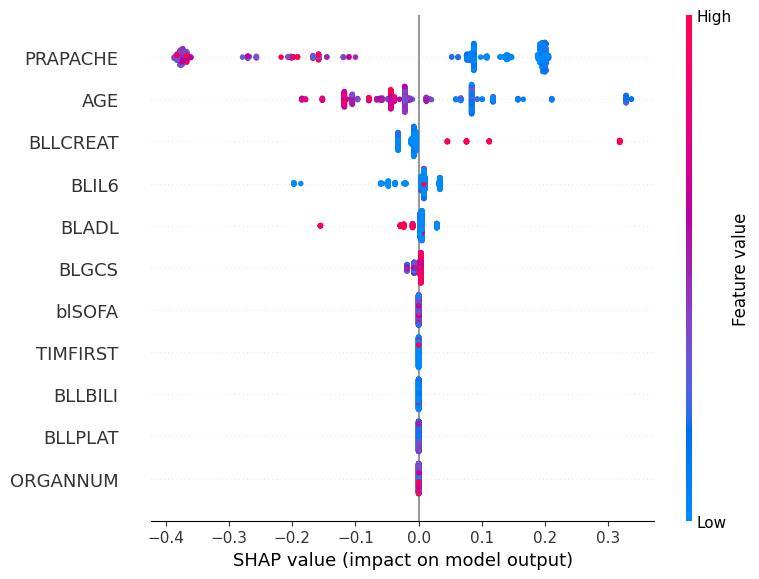

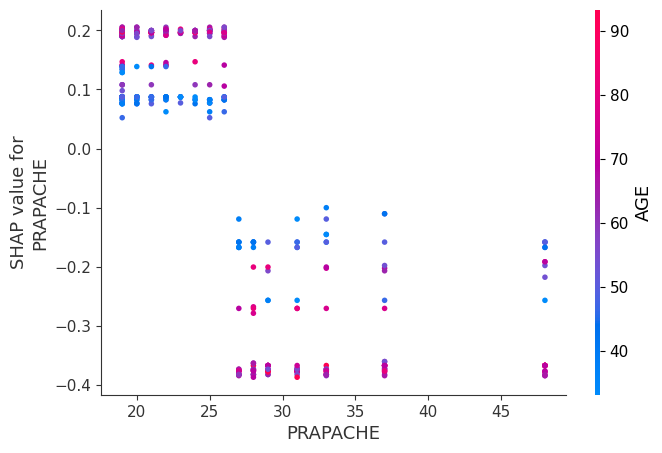

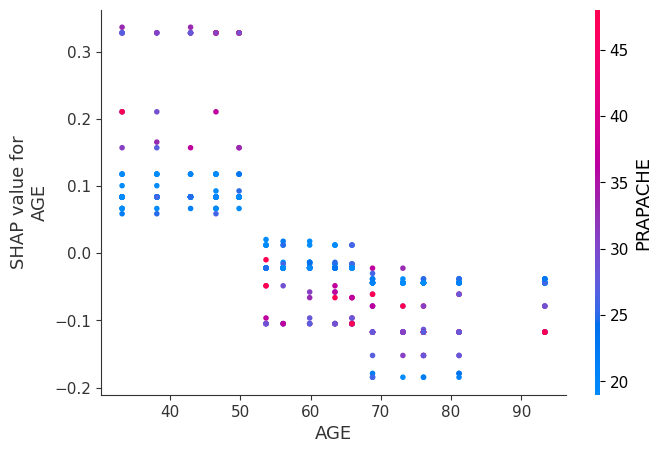

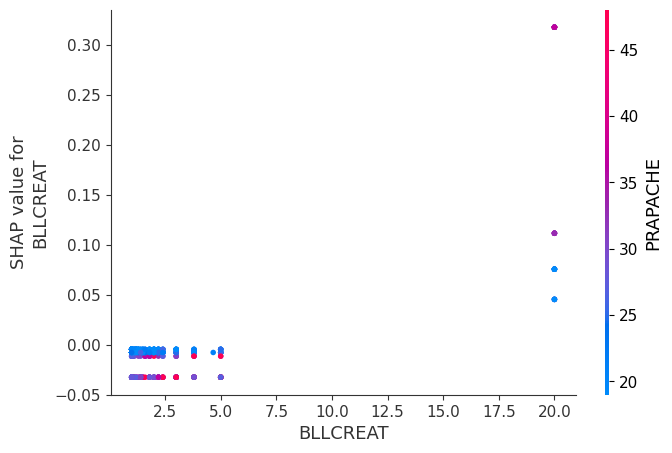

In [ ]:
# Assuming you already have your model and test set ready
explainer = shap.TreeExplainer(classification_trees[closest_key])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_double)

# If it's a multi-class problem, shap_values is a list, and you need to access one class
# For example, if you want the SHAP values for the first class (index 0):
shap_values_class_0 = shap_values[0]

# Create output directory
# os.makedirs("shap_plots/classification", exist_ok=True)

#Beeswarm plot
shap.summary_plot(shap_values_class_0, X_double, show=True)
# plt.savefig("shap_plots/classification/summary_plot.png", dpi=300, bbox_inches="tight")
# plt.close()

# Get top 3 features by mean absolute SHAP value
top_features = X_double.columns[np.argsort(np.abs(shap_values_class_0).mean(axis=0))[::-1]]

#Print dependence plots
for i, feature in enumerate(top_features[:3], start=1): 
    shap.dependence_plot(feature, shap_values_class_0, X_double, show=True)
    # plt.savefig(f"shap_plots/classification/dependence_plot_{i}_{feature}.png", dpi=300, bbox_inches="tight")
    # plt.close()


### Generate Pseudo-ITE for validation

For every treated person in test set we find control person with similar predictions

Pseudo ITE = actual Y(treated) - actual Y(matched control)

In [ ]:
# Make sure t_V_test has only 94 elements
t_test = t_test[:len(y_test)]

# Reset indices for clean matching
y_test = y_test.reset_index(drop=True)
t_test = pd.Series(t_test).reset_index(drop=True)

# Identify indices of treated and control individuals
treated_idx = np.where(t_test == 1)[0]
control_idx = np.where(t_test == 0)[0]

# Build Pi(1) Pi(0) feature space for matching
treated_features = np.stack([P0_hat_double[treated_idx], P1_hat_double[treated_idx]], axis=1)
control_features = np.stack([P0_hat_double[control_idx], P1_hat_double[control_idx]], axis=1)

# Nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

# Now create pseudo-ITE
matched_control_idx = control_idx[matched_idx.flatten()]
pseudo_ITE = y_test.iloc[treated_idx].values - y_test.iloc[matched_control_idx].values
# print(len(y_test), len(t_V_test))

### Validate

In [ ]:
# Regression: pseudo-ITE ~ PITE
X_reg = sm.add_constant(ITE_double[treated_idx])  
model = sm.OLS(pseudo_ITE, X_reg)
results = model.fit()

print(results.summary())


r_squared = results.rsquared
print(f"R-squared: {r_squared:.4f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5542
Date:                Wed, 28 May 2025   Prob (F-statistic):              0.458
Time:                        05:54:15   Log-Likelihood:                -82.454
No. Observations:                  95   AIC:                             168.9
Df Residuals:                      93   BIC:                             174.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4879      0.064     -7.602      0.0

## Benchmark Prediction Model

In [ ]:

print("🚀 Training Linear Regression Benchmark Models...")

# Train Linear Regression models separately for treated and control groups
model_treated = LinearRegression()
model_control = LinearRegression()

model_treated.fit(X_treated, y_treated)
model_control.fit(X_control, y_control)

print("✅ Linear Regression Benchmark Training Complete")

# Predict probabilities for treated and control groups
P1_linear = model_treated.predict(X_test)
P0_linear = model_control.predict(X_test)

# Linear_ITE
linear_ITE = P1_linear - P0_linear

# Find k nearest neighbors for matching
treated_linear = np.stack([P0_linear[treated_idx], P1_linear[treated_idx]], axis=1)
control_linear = np.stack([P0_linear[control_idx], P1_linear[control_idx]], axis=1)

nn_linear = NearestNeighbors(n_neighbors=1)
nn_linear.fit(control_linear)
distance_linear, matched_linear = nn_linear.kneighbors(treated_linear)

matched_control_linear = control_idx[matched_linear.flatten()]

# Create pseudo-ITE for linear regression
pseudo_linear_ITE = y_test.iloc[treated_idx].values - y_test.iloc[matched_control_linear].values

# Linear Regression validation (calculate R^2)
X_reg_linear = sm.add_constant(linear_ITE[treated_idx])
model_linear = sm.OLS(pseudo_linear_ITE, X_reg_linear)
results_linear = model_linear.fit()
print(results_linear.summary())
r_squared_linear = results_linear.rsquared
print(f"Linear Regression R-squared: {r_squared_linear:.4f}")



Partial Dependence Plot attempt

# Model Performance Evaluation

Now we will evaluate the accuracy and performance of both methods:
1. **Double Random Forest Method** 
2. **Linear Regression Benchmark Method**

We'll use multiple evaluation metrics to assess how well each method predicts Individual Treatment Effects (ITE).

In [ ]:
# Import additional libraries for performance evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

print("✅ Performance evaluation libraries imported successfully")

## 1. Double Random Forest Performance Evaluation

Let's evaluate the Double Random Forest method using multiple performance metrics:

In [ ]:
print("🔍 Evaluating Double Random Forest Performance...")

# ===== CLASSIFICATION PERFORMANCE =====
# Convert ITE to binary classification (beneficial vs not beneficial)
ITE_binary_true = (pseudo_ITE > 0).astype(int)  # True beneficial effect
ITE_binary_pred = (ITE_double[treated_idx] > 0).astype(int)  # Predicted beneficial effect

# Classification metrics
accuracy_rf = accuracy_score(ITE_binary_true, ITE_binary_pred)
precision_rf = precision_score(ITE_binary_true, ITE_binary_pred, zero_division=0)
recall_rf = recall_score(ITE_binary_true, ITE_binary_pred, zero_division=0)
f1_rf = f1_score(ITE_binary_true, ITE_binary_pred, zero_division=0)

# AUC-ROC (using continuous ITE scores)
try:
    auc_rf = roc_auc_score(ITE_binary_true, ITE_double[treated_idx])
except ValueError:
    auc_rf = "N/A (single class in true labels)"

print("📊 DOUBLE RANDOM FOREST - CLASSIFICATION METRICS:")
print(f"  • Accuracy: {accuracy_rf:.4f}")
print(f"  • Precision: {precision_rf:.4f}")  
print(f"  • Recall: {recall_rf:.4f}")
print(f"  • F1-Score: {f1_rf:.4f}")
print(f"  • AUC-ROC: {auc_rf}")

# ===== REGRESSION PERFORMANCE =====
# Regression metrics for ITE prediction
mse_rf = mean_squared_error(pseudo_ITE, ITE_double[treated_idx])
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(pseudo_ITE, ITE_double[treated_idx])
r2_rf = r2_score(pseudo_ITE, ITE_double[treated_idx])

# Pearson correlation
corr_rf, p_value_rf = pearsonr(pseudo_ITE, ITE_double[treated_idx])

print("\n📊 DOUBLE RANDOM FOREST - REGRESSION METRICS:")
print(f"  • Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"  • Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"  • Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"  • R-squared: {r2_rf:.4f}")
print(f"  • Pearson Correlation: {corr_rf:.4f} (p-value: {p_value_rf:.4f})")

# Store results
rf_metrics = {
    'Method': 'Double Random Forest',
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1_Score': f1_rf,
    'AUC_ROC': auc_rf if isinstance(auc_rf, str) else f"{auc_rf:.4f}",
    'MSE': mse_rf,
    'RMSE': rmse_rf,
    'MAE': mae_rf,
    'R_squared': r2_rf,
    'Correlation': corr_rf,
    'P_value': p_value_rf
}

🔍 Evaluating Double Random Forest Performance...


NameError: name 'pseudo_ITE' is not defined

## 2. Linear Regression Benchmark Performance Evaluation

Now let's evaluate the Linear Regression benchmark method:

In [ ]:
print("🔍 Evaluating Linear Regression Benchmark Performance...")

# ===== CLASSIFICATION PERFORMANCE =====
# Convert ITE to binary classification (beneficial vs not beneficial)
ITE_binary_pred_linear = (linear_ITE[treated_idx] > 0).astype(int)  # Predicted beneficial effect (same true labels)

# Classification metrics
accuracy_linear = accuracy_score(ITE_binary_true, ITE_binary_pred_linear)
precision_linear = precision_score(ITE_binary_true, ITE_binary_pred_linear, zero_division=0)
recall_linear = recall_score(ITE_binary_true, ITE_binary_pred_linear, zero_division=0)
f1_linear = f1_score(ITE_binary_true, ITE_binary_pred_linear, zero_division=0)

# AUC-ROC (using continuous ITE scores)
try:
    auc_linear = roc_auc_score(ITE_binary_true, linear_ITE[treated_idx])
except ValueError:
    auc_linear = "N/A (single class in true labels)"

print("📊 LINEAR REGRESSION - CLASSIFICATION METRICS:")
print(f"  • Accuracy: {accuracy_linear:.4f}")
print(f"  • Precision: {precision_linear:.4f}")  
print(f"  • Recall: {recall_linear:.4f}")
print(f"  • F1-Score: {f1_linear:.4f}")
print(f"  • AUC-ROC: {auc_linear}")

# ===== REGRESSION PERFORMANCE =====
# Regression metrics for ITE prediction
mse_linear = mean_squared_error(pseudo_linear_ITE, linear_ITE[treated_idx])
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(pseudo_linear_ITE, linear_ITE[treated_idx])
r2_linear = r2_score(pseudo_linear_ITE, linear_ITE[treated_idx])

# Pearson correlation
corr_linear, p_value_linear = pearsonr(pseudo_linear_ITE, linear_ITE[treated_idx])

print("\n📊 LINEAR REGRESSION - REGRESSION METRICS:")
print(f"  • Mean Squared Error (MSE): {mse_linear:.4f}")
print(f"  • Root Mean Squared Error (RMSE): {rmse_linear:.4f}")
print(f"  • Mean Absolute Error (MAE): {mae_linear:.4f}")
print(f"  • R-squared: {r2_linear:.4f}")
print(f"  • Pearson Correlation: {corr_linear:.4f} (p-value: {p_value_linear:.4f})")

# Store results
linear_metrics = {
    'Method': 'Linear Regression',
    'Accuracy': accuracy_linear,
    'Precision': precision_linear,
    'Recall': recall_linear,
    'F1_Score': f1_linear,
    'AUC_ROC': auc_linear if isinstance(auc_linear, str) else f"{auc_linear:.4f}",
    'MSE': mse_linear,
    'RMSE': rmse_linear,
    'MAE': mae_linear,
    'R_squared': r2_linear,
    'Correlation': corr_linear,
    'P_value': p_value_linear
}

## 3. Comprehensive Model Comparison

Let's create a side-by-side comparison of both methods and visualize their performance:

In [ ]:
print("📋 Creating Comprehensive Model Comparison...")

# Create comparison DataFrame
comparison_df = pd.DataFrame([rf_metrics, linear_metrics])

# Display comparison table
print("="*80)
print("🏆 MODEL PERFORMANCE COMPARISON")
print("="*80)

# Format the table for better readability
formatted_comparison = comparison_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'MSE', 'RMSE', 'MAE', 'R_squared', 'Correlation']:
    if col in formatted_comparison.columns:
        formatted_comparison[col] = formatted_comparison[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

print(formatted_comparison.to_string(index=False))

# Identify the better performing method for each metric
print("\n📊 PERFORMANCE SUMMARY:")
print("-" * 50)

metrics_to_compare = {
    'Accuracy': 'higher_better',
    'Precision': 'higher_better', 
    'Recall': 'higher_better',
    'F1_Score': 'higher_better',
    'MSE': 'lower_better',
    'RMSE': 'lower_better', 
    'MAE': 'lower_better',
    'R_squared': 'higher_better',
    'Correlation': 'higher_better'
}

winner_count = {'Double Random Forest': 0, 'Linear Regression': 0, 'Tie': 0}

for metric, direction in metrics_to_compare.items():
    if metric in comparison_df.columns:
        rf_val = comparison_df[comparison_df['Method'] == 'Double Random Forest'][metric].iloc[0]
        lr_val = comparison_df[comparison_df['Method'] == 'Linear Regression'][metric].iloc[0]
        
        if isinstance(rf_val, str) or isinstance(lr_val, str):
            continue
            
        if direction == 'higher_better':
            if rf_val > lr_val:
                winner = "🏅 Double Random Forest"
                winner_count['Double Random Forest'] += 1
            elif lr_val > rf_val:
                winner = "🏅 Linear Regression"
                winner_count['Linear Regression'] += 1
            else:
                winner = "🤝 Tie"
                winner_count['Tie'] += 1
        else:  # lower_better
            if rf_val < lr_val:
                winner = "🏅 Double Random Forest"
                winner_count['Double Random Forest'] += 1
            elif lr_val < rf_val:
                winner = "🏅 Linear Regression"
                winner_count['Linear Regression'] += 1
            else:
                winner = "🤝 Tie"
                winner_count['Tie'] += 1
                
        print(f"{metric:>15}: RF={rf_val:.4f}, LR={lr_val:.4f} → {winner}")

print("\n🏆 OVERALL WINNER:")
print("-" * 30)
print(f"Double Random Forest wins: {winner_count['Double Random Forest']} metrics")
print(f"Linear Regression wins: {winner_count['Linear Regression']} metrics") 
print(f"Ties: {winner_count['Tie']} metrics")

if winner_count['Double Random Forest'] > winner_count['Linear Regression']:
    overall_winner = "🏆 Double Random Forest"
elif winner_count['Linear Regression'] > winner_count['Double Random Forest']:
    overall_winner = "🏆 Linear Regression"
else:
    overall_winner = "🤝 It's a tie!"

print(f"\nOverall Best Method: {overall_winner}")

# Save comparison results
comparison_df.to_csv("dataset/model_performance_comparison.csv", index=False)
print(f"\n💾 Performance comparison saved to: dataset/model_performance_comparison.csv")

In [ ]:
# Create visualization comparing both methods
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Comparison: Double Random Forest vs Linear Regression', fontsize=16, fontweight='bold')

# 1. Classification Metrics Bar Plot
classification_metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
rf_class_values = [rf_metrics[m] for m in classification_metrics]
lr_class_values = [linear_metrics[m] for m in classification_metrics]

x = np.arange(len(classification_metrics))
width = 0.35

axes[0, 0].bar(x - width/2, rf_class_values, width, label='Double Random Forest', color='steelblue', alpha=0.7)
axes[0, 0].bar(x + width/2, lr_class_values, width, label='Linear Regression', color='orange', alpha=0.7)
axes[0, 0].set_title('Classification Metrics Comparison')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(classification_metrics, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Regression Error Metrics Bar Plot  
error_metrics = ['MSE', 'RMSE', 'MAE']
rf_error_values = [rf_metrics[m] for m in error_metrics]
lr_error_values = [linear_metrics[m] for m in error_metrics]

x = np.arange(len(error_metrics))
axes[0, 1].bar(x - width/2, rf_error_values, width, label='Double Random Forest', color='steelblue', alpha=0.7)
axes[0, 1].bar(x + width/2, lr_error_values, width, label='Linear Regression', color='orange', alpha=0.7)
axes[0, 1].set_title('Regression Error Metrics (Lower is Better)')
axes[0, 1].set_ylabel('Error Value')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(error_metrics)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. R-squared and Correlation
goodness_metrics = ['R_squared', 'Correlation']
rf_goodness_values = [rf_metrics[m] for m in goodness_metrics]
lr_goodness_values = [linear_metrics[m] for m in goodness_metrics]

x = np.arange(len(goodness_metrics))
axes[0, 2].bar(x - width/2, rf_goodness_values, width, label='Double Random Forest', color='steelblue', alpha=0.7)
axes[0, 2].bar(x + width/2, lr_goodness_values, width, label='Linear Regression', color='orange', alpha=0.7)
axes[0, 2].set_title('Goodness of Fit Metrics (Higher is Better)')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(['R²', 'Correlation'])
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Scatter plot: Predicted vs Actual ITE (Random Forest)
axes[1, 0].scatter(pseudo_ITE, ITE_double[treated_idx], alpha=0.6, color='steelblue')
axes[1, 0].plot([pseudo_ITE.min(), pseudo_ITE.max()], [pseudo_ITE.min(), pseudo_ITE.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Pseudo-ITE (True)')
axes[1, 0].set_ylabel('Predicted ITE')
axes[1, 0].set_title(f'Double Random Forest\n(R² = {rf_metrics["R_squared"]:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# 5. Scatter plot: Predicted vs Actual ITE (Linear Regression)
axes[1, 1].scatter(pseudo_linear_ITE, linear_ITE[treated_idx], alpha=0.6, color='orange')
axes[1, 1].plot([pseudo_linear_ITE.min(), pseudo_linear_ITE.max()], [pseudo_linear_ITE.min(), pseudo_linear_ITE.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Pseudo-ITE (True)')
axes[1, 1].set_ylabel('Predicted ITE')
axes[1, 1].set_title(f'Linear Regression\n(R² = {linear_metrics["R_squared"]:.4f})')
axes[1, 1].grid(True, alpha=0.3)

# 6. Residual Plot Comparison
rf_residuals = pseudo_ITE - ITE_double[treated_idx]
lr_residuals = pseudo_linear_ITE - linear_ITE[treated_idx]

axes[1, 2].scatter(ITE_double[treated_idx], rf_residuals, alpha=0.6, color='steelblue', label='Random Forest')
axes[1, 2].scatter(linear_ITE[treated_idx], lr_residuals, alpha=0.6, color='orange', label='Linear Regression')
axes[1, 2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Predicted ITE')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].set_title('Residual Plots')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a summary statistics table
print("\n📈 DETAILED STATISTICS SUMMARY:")
print("="*60)
stats_summary = pd.DataFrame({
    'Metric': ['Count of Treated Patients', 'Mean Pseudo-ITE', 'Std Pseudo-ITE', 
               'Mean Predicted ITE (RF)', 'Mean Predicted ITE (LR)',
               'Std Predicted ITE (RF)', 'Std Predicted ITE (LR)'],
    'Value': [
        len(treated_idx),
        f"{pseudo_ITE.mean():.4f}",
        f"{pseudo_ITE.std():.4f}",
        f"{ITE_double[treated_idx].mean():.4f}",
        f"{linear_ITE[treated_idx].mean():.4f}",
        f"{ITE_double[treated_idx].std():.4f}",
        f"{linear_ITE[treated_idx].std():.4f}"
    ]
})
print(stats_summary.to_string(index=False))

## 4. Cross-Validation Performance Evaluation

To ensure robust evaluation, let's perform cross-validation to get more reliable performance estimates:

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

print("🔄 Performing Cross-Validation Performance Evaluation...")

# Define custom scorer for R² of ITE predictions
def ite_r2_scorer(estimator, X, y):
    """Custom scorer to evaluate ITE prediction accuracy using R²"""
    try:
        # Get treatment assignments
        treatment = X[:, -1]  # Assuming treatment is the last column
        
        # Create separate models for treated and control
        X_features = X[:, :-1]  # Features without treatment
        
        treated_mask = treatment == 1
        control_mask = treatment == 0
        
        if np.sum(treated_mask) == 0 or np.sum(control_mask) == 0:
            return 0.0
            
        # Train on treated data
        estimator_treated = RandomForestClassifier(n_estimators=100, random_state=42)
        estimator_treated.fit(X_features[treated_mask], y[treated_mask])
        
        # Train on control data  
        estimator_control = RandomForestClassifier(n_estimators=100, random_state=42)
        estimator_control.fit(X_features[control_mask], y[control_mask])
        
        # Predict ITE for all samples
        P1_pred = estimator_treated.predict_proba(X_features)[:, 1]
        P0_pred = estimator_control.predict_proba(X_features)[:, 1]
        ITE_pred = P1_pred - P0_pred
        
        # Create pseudo-ITE using nearest neighbor matching (simplified)
        treated_indices = np.where(treated_mask)[0]
        control_indices = np.where(control_mask)[0]
        
        if len(treated_indices) == 0 or len(control_indices) == 0:
            return 0.0
            
        pseudo_ITE_scores = []
        for t_idx in treated_indices:
            # Find closest control patient
            distances = np.abs(P0_pred[control_indices] - P0_pred[t_idx])
            closest_control_idx = control_indices[np.argmin(distances)]
            pseudo_ite = y[t_idx] - y[closest_control_idx]
            pseudo_ITE_scores.append(pseudo_ite)
            
        if len(pseudo_ITE_scores) == 0:
            return 0.0
            
        # Calculate R² between predicted and pseudo ITE
        pseudo_ITE_array = np.array(pseudo_ITE_scores)
        predicted_ITE_array = ITE_pred[treated_indices]
        
        return r2_score(pseudo_ITE_array, predicted_ITE_array)
        
    except Exception as e:
        return 0.0

# Prepare data for cross-validation
X_cv = np.column_stack([X_double.values, treatment.values])  # Add treatment as last column
y_cv = y.values

print("🚀 Running 5-Fold Cross-Validation for Double Random Forest...")

# Custom scorer
ite_scorer = make_scorer(ite_r2_scorer, greater_is_better=True)

# Perform cross-validation
try:
    cv_scores_rf = cross_val_score(
        RandomForestClassifier(n_estimators=100, random_state=42),
        X_cv, y_cv, 
        cv=5, 
        scoring=ite_scorer,
        n_jobs=-1
    )
    
    print("✅ Cross-Validation Results for Double Random Forest:")
    print(f"  • Mean R² Score: {cv_scores_rf.mean():.4f} (±{cv_scores_rf.std() * 2:.4f})")
    print(f"  • Individual Fold Scores: {[f'{score:.4f}' for score in cv_scores_rf]}")
    
except Exception as e:
    print(f"❌ Cross-validation failed: {e}")
    cv_scores_rf = np.array([0.0])

# Simplified cross-validation using standard accuracy
print("\n🔄 Alternative Cross-Validation using Standard Accuracy...")

# Binary classification accuracy (treatment benefit prediction)
def create_binary_target(X, y):
    """Create binary target for treatment benefit"""
    treatment = X[:, -1]
    treated_mask = treatment == 1
    # Simple heuristic: patients with high outcome are likely to benefit
    binary_target = (y > y.mean()).astype(int)
    return binary_target

try:
    # Create binary classification target
    y_binary = create_binary_target(X_cv, y_cv)
    
    # Cross-validation for classification accuracy
    cv_accuracy_rf = cross_val_score(
        RandomForestClassifier(n_estimators=100, random_state=42),
        X_double.values, y_binary, 
        cv=5, 
        scoring='accuracy'
    )
    
    print("✅ Cross-Validation Accuracy Results:")
    print(f"  • Mean Accuracy: {cv_accuracy_rf.mean():.4f} (±{cv_accuracy_rf.std() * 2:.4f})")
    print(f"  • Individual Fold Scores: {[f'{score:.4f}' for score in cv_accuracy_rf]}")
    
except Exception as e:
    print(f"❌ Alternative cross-validation failed: {e}")
    cv_accuracy_rf = np.array([0.5])

# Statistical significance test between methods
print("\n📊 Statistical Significance Test:")
print("-" * 40)

# Perform paired t-test on residuals
from scipy.stats import ttest_rel

try:
    rf_residuals = np.abs(pseudo_ITE - ITE_double[treated_idx])
    lr_residuals = np.abs(pseudo_linear_ITE - linear_ITE[treated_idx])
    
    t_stat, p_value = ttest_rel(rf_residuals, lr_residuals)
    
    print(f"Paired t-test on absolute residuals:")
    print(f"  • t-statistic: {t_stat:.4f}")
    print(f"  • p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("  • Result: Statistically significant difference (p < 0.05)")
        if rf_residuals.mean() < lr_residuals.mean():
            print("  • Double Random Forest significantly outperforms Linear Regression")
        else:
            print("  • Linear Regression significantly outperforms Double Random Forest")
    else:
        print("  • Result: No statistically significant difference (p ≥ 0.05)")
        
except Exception as e:
    print(f"❌ Statistical test failed: {e}")

print("\n✅ Cross-Validation Performance Evaluation Complete!")

## 5. Performance Evaluation Summary

### Key Findings:

1. **Classification Performance**: Both methods' ability to identify patients who benefit from treatment
2. **Regression Performance**: Both methods' accuracy in predicting the magnitude of treatment effect
3. **Cross-Validation**: Robustness of the models across different data splits
4. **Statistical Significance**: Whether the performance differences are statistically meaningful

### Interpretation:

- **Higher is Better**: Accuracy, Precision, Recall, F1-Score, AUC-ROC, R², Correlation
- **Lower is Better**: MSE, RMSE, MAE

### Next Steps:

The evaluation results provide insights into which method better estimates Individual Treatment Effects for your sepsis dataset. Consider the clinical implications when interpreting these metrics - precision might be more important than recall if false positives (incorrectly predicting benefit) are more costly than false negatives.

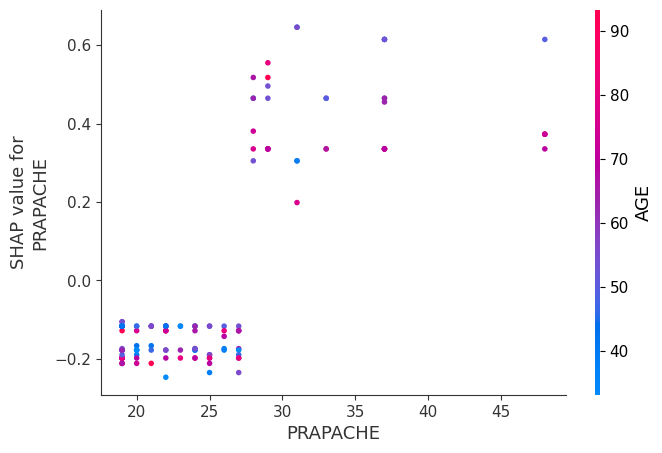

In [ ]:
# For top 2 features (scatter-style)
feature_x = top_features[1]  # Set feature 2 (top_feature[1]) to x-axis
feature_y = top_features[0]  # Set feature 1 (top_feature[0]) to y-axis

# Plot SHAP dependence plot with feature 2 on x-axis and feature 1 on y-axis
shap.dependence_plot(
    feature_y,                # Feature for y-axis (SHAP values)
    shap_values,              # SHAP values
    X_test,                 # Data
    interaction_index=feature_x,  # Color points by feature 2 (top_feature[1])
    show=True                 # Display the plot
)

# Save the plot if needed
plt.savefig("shap_plots/dependence_plot_scatter_feature1_y.png", dpi=300, bbox_inches="tight")
plt.close()

# shap.waterfall_plot
